In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "data/train"
categories = ["g80", "gv70", "gv80", "kia stinger"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

g80  파일 길이 :  1191
g80  :  data/train/g80\g80_1.jpg
g80  :  data/train/g80\g80_557.jpg
gv70  파일 길이 :  335
gv70  :  data/train/gv70\gv70_1.jpg
gv80  파일 길이 :  1665
gv80  :  data/train/gv80\gv80_1.jpg
gv80  :  data/train/gv80\gv80_1629.jpg
gv80  :  data/train/gv80\gv80_760.jpg
kia stinger  파일 길이 :  666
kia stinger  :  data/train/kia stinger\kia stinger_1.jpg
ok 3857


In [9]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('numpy_data/multi_image_data.npy')
print(X_train.shape)
print(X_train.shape[0])

(2892, 64, 64, 3)
2892


In [10]:
categories = ["g80", "gv70", "gv80", "kia stinger"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9934898708060034247
]


In [12]:
with K.tf_ops.device('/device:CPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = 'model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)            

In [15]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=2)

Train on 2892 samples, validate on 965 samples
Epoch 1/50
 - 10s - loss: 1.0979 - accuracy: 0.5190 - val_loss: 1.0931 - val_accuracy: 0.5513
Epoch 2/50
 - 11s - loss: 1.0129 - accuracy: 0.5716 - val_loss: 1.0101 - val_accuracy: 0.5865
Epoch 3/50
 - 11s - loss: 0.9075 - accuracy: 0.6151 - val_loss: 0.9380 - val_accuracy: 0.6228
Epoch 4/50
 - 11s - loss: 0.8022 - accuracy: 0.6642 - val_loss: 0.9016 - val_accuracy: 0.6290
Epoch 5/50
 - 10s - loss: 0.7166 - accuracy: 0.7199 - val_loss: 0.8165 - val_accuracy: 0.6705
Epoch 6/50
 - 10s - loss: 0.6332 - accuracy: 0.7455 - val_loss: 0.8367 - val_accuracy: 0.6446
Epoch 7/50
 - 10s - loss: 0.5312 - accuracy: 0.8022 - val_loss: 0.7499 - val_accuracy: 0.7098
Epoch 8/50
 - 11s - loss: 0.4750 - accuracy: 0.8209 - val_loss: 0.7578 - val_accuracy: 0.6995
Epoch 9/50
 - 11s - loss: 0.3762 - accuracy: 0.8555 - val_loss: 0.6975 - val_accuracy: 0.7347
Epoch 10/50
 - 11s - loss: 0.3198 - accuracy: 0.8838 - val_loss: 0.6885 - val_accuracy: 0.7337
Epoch 11/50


In [16]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

965/965 [==============================] - 1s 706us/step
정확도 : 0.7731


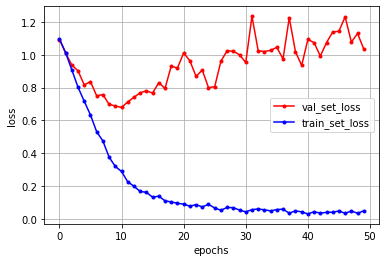

In [18]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [21]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "data/test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "g80"
    elif pre_ans == 1: pre_ans_str = "gv70"
    elif pre_ans == 2: pre_ans_str = "gv80"
    else: pre_ans_str = "kia stinger"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[1.000 0.000 0.000 0.000]
0
해당 1.jpg이미지는 g80로 추정됩니다.
[1.000 0.000 0.000 0.000]
0
해당 3.jpg이미지는 g80로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 4.jpg이미지는 kia stinger로 추정됩니다.
[1.000 0.000 0.000 0.000]
0
해당 5.jpg이미지는 g80로 추정됩니다.
[0.000 0.000 0.000 1.000]
3
해당 6.jpg이미지는 kia stinger로 추정됩니다.
[1.000 0.000 0.000 0.000]
0
해당 7.jpg이미지는 g80로 추정됩니다.
